In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import yfinance as yf

In [ ]:
sp500 = yf.Ticker("SPY")

In [ ]:
sp500 = sp500.history("max")

In [ ]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-03-25 00:00:00-05:00,5.246200,5.268813,5.133135,5.178361,20047500,0.0,0.0
1993-03-26 00:00:00-05:00,5.178369,5.268820,5.155755,5.200981,5826000,0.0,0.0
1993-03-29 00:00:00-05:00,5.155752,5.200978,5.110527,5.133139,2249400,0.0,0.0
1993-03-30 00:00:00-05:00,5.110527,5.133139,5.065300,5.133139,2520900,0.0,0.0
1993-03-31 00:00:00-05:00,5.110523,5.268814,5.110523,5.246201,2130900,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-20 00:00:00-04:00,274.739990,275.369995,264.029999,264.140015,2071200,0.0,0.0
2024-05-21 00:00:00-04:00,264.959991,267.290009,264.619995,265.000000,1413100,0.0,0.0
2024-05-22 00:00:00-04:00,265.100006,268.950012,265.019989,267.440002,1687300,0.0,0.0


<Axes: xlabel='Date'>

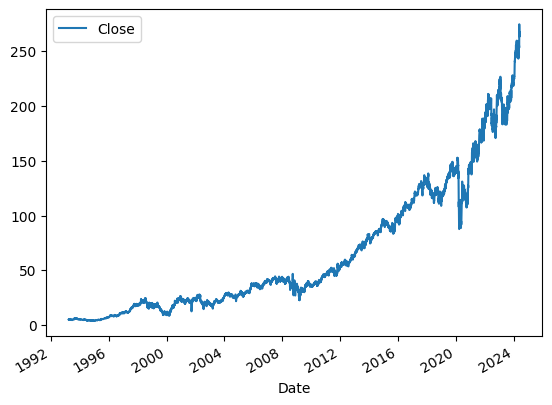

In [ ]:
sp500.plot.line(y="Close", use_index = True)

SPY stock over the years

In [ ]:
del sp500['Dividends']
del sp500['Stock Splits']
sp500["Tomorrow"] = sp500['Close'].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500['Close']).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 500, min_samples_split=70, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])


In [ ]:
from sklearn.metrics import precision_score
import pandas as pd

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [ ]:
precision_score(test["Target"], preds)

Beginning precision score of 55%

In [ ]:
combined = pd.concat([test["Target"], preds], axis = 1)
combined.plot()

Most of the time the model predicted it to go up. We need to do something about that since it is not accurate.

In [ ]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis = 1)
  return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500, model, predictors)
predictions["Predictions"].value_counts()

Predictions
0    3529
1    1820
Name: count, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5318681318681319

We need to add more predictors

In [ ]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
  rolling_avr = sp500.rolling(horizon).mean()

  ratio_column = f"Close Ratio_{horizon}"
  sp500[ratio_column] = sp500["Close"] / rolling_avr["Close"]

  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio_column, trend_column]

sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close Ratio_2,Trend_2,Close Ratio_5,Trend_5,Close Ratio_60,Trend_60,Close Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,
1994-03-21 00:00:00-05:00,4.966926,4.989922,4.920937,4.920937,94500,4.966927,1,0.995349,1.0,0.999066,3.0,0.944395,24.0,0.900931,103.0
1994-03-22 00:00:00-05:00,4.966927,4.966927,4.920937,4.966927,139200,4.920937,0,1.004651,1.0,1.007463,3.0,0.954555,24.0,0.909507,103.0
1994-03-23 00:00:00-05:00,4.989922,4.989922,4.920937,4.920937,233400,4.920937,0,0.995349,1.0,0.996276,3.0,0.947601,23.0,0.901226,103.0
1994-03-24 00:00:00-05:00,4.966926,4.966926,4.920937,4.920937,139500,4.916322,0,1.000000,0.0,0.996276,2.0,0.949423,23.0,0.901366,103.0
1994-03-25 00:00:00-05:00,4.893240,4.916322,4.870159,4.916322,118200,4.916322,0,0.999531,0.0,0.997385,1.0,0.950656,22.0,0.900738,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-17 00:00:00-04:00,267.399994,275.410004,266.209991,274.279999,4303300,264.140015,0,1.017435,2.0,1.055061,2.0,1.086470,30.0,1.239317,132.0
2024-05-20 00:00:00-04:00,274.739990,275.369995,264.029999,264.140015,2071200,265.000000,1,0.981167,1.0,1.008607,2.0,1.045685,29.0,1.192012,132.0
2024-05-21 00:00:00-04:00,264.959991,267.290009,264.619995,265.000000,1413100,267.440002,1,1.001625,1.0,1.002823,3.0,1.048328,30.0,1.194349,133.0


In [ ]:
model = RandomForestClassifier(n_estimators=500, min_samples_split = 50, random_state=1)

def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= .55] = 1
  preds[preds < .55] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis = 1)
  return combined

In [ ]:
predictions = backtest(sp500, model, new_predictors)
predictions["Predictions"].value_counts()

Predictions
0.0    2860
1.0    1526
Name: count, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5445609436435125